In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt

from IPython.display import HTML
%matplotlib inline

pd.options.display.precision = 15
pd.options.display.max_rows = 500

import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import requests
import time, random

import re
import gensim
from gensim.models import CoherenceModel

unable to import 'smart_open.gcs', disabling that module


## 1. Scrape Job Adverts from Indeed

The webpage address "https://www.indeed.co.uk/jobs?q=data+scientist&l=London%2C+Greater+London&sort=date&start=" will load the jobs on indeed in the Greater London area from the date posted, with newest postings appearing first. By adding 0, 10, 20 etc. after the address the page will load the first, second, third etc. page of results. From testing out the indeed max search pages it stops around 40 so for the purpose of this analysis will just scrape 40 pages of job advert data.

In [ ]:
links = []
links1 = []
links2 = []
links3 = []

#3 different types of job advert links can be retured from the initial indeed search page. They contain either:
#- "rc/"
#- "jobs/"
#- "pagead/"

#By search for these 3 different types of ads and combining, all the job links can be returned 

for i in range(0, 40):
    url = "https://www.indeed.co.uk/jobs?q=data+scientist&l=London%2C+Greater+London&sort=date&start=" + str(i * 10)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    for link in soup.findAll('a', attrs={'href': re.compile("rc/")}):
        links1.append(link.get("href"))
    

    for link in soup.findAll('a', attrs={'href': re.compile("jobs/")}):
        links2.append(link.get("href"))
    

    for link in soup.findAll('a', attrs={'href': re.compile("pagead/")}):
        links3.append(link.get("href"))
        
    links_comb = links1 + links2 + links3
    links.append(links_comb)
    
job_links = [num for elem in links_comb for num in elem]

In [ ]:
#A function to return job location, contract type and salary. Not all adverts contain this information so the following function
#returns blank for any one of these that is missing. If salary but not contract type is returned, I correct the variable 
#it is assigned to so that the function will return location, contract and salary in that order for all job postings.

def extract_contract_info(contract_info):
    
    location = ''
    salary = ''
    contract = ''
    
    for i, location_type in enumerate(contract_info):
        if i == 0:
            try:
                location=contract_info[i]
            except:
                location=''
        elif i == 1:
            try:
                contract=contract_info[i]
            except:
                contract=''
        else:
            try:
                salary=contract_info[i]
            except:
                salary=''

    try:
        if re.search("£", contract):
            salary = contract
            contract = ''
    except:
        contract = ''
        salary = ''
    
    
    return(location, contract, salary)

In [ ]:
# Empty dataframe in which to store data scraped from job adverts
data = pd.DataFrame(columns = ['job_title','company', 'location', 'contract', 'salary', 'job_description'])

In [ ]:
#Loops through each link and using the html class found on indeed returns job title, company, contract information and 
#job description

for link in job_links:
    
    url = 'https://www.indeed.co.uk' + link
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    job_h = soup.find_all('div', {'class':'jobsearch-JobInfoHeader-title-container'})
    job_title = [e.get_text() for e in job_h] 

    comp_h = soup.find_all('div', {'class':'icl-u-lg-mr--sm icl-u-xs-mr--xs'})
    company = [e.get_text() for e in comp_h] 

    desc = soup.find_all('div', {'class':'jobsearch-jobDescriptionText'})
    text = [e.get_text() for e in desc]
    job_desc = [x.replace('\n', ' ') for x in text]
    
    contr_h = soup.find_all('div', {'class':'jobsearch-JobMetadataHeader-itemWithIcon'})
    contract_info = [e.get_text() for e in contr_h]

    ext = extract_contract_info(contract_info)

    location = ext[0]
    contract = ext[1]
    salary = ext[2]

    data = data.append({'Role':job_title[0],
                        'Company':company[0],
                        'Location':location,
                        'Contract':contract,
                        'Salary':salary,
                        'Job_description':job_desc},ignore_index=True)  
    
    time.sleep(5 + random.randint(0,5))

In [ ]:
data.to_csv('indeed_data.csv')

## 2. Analysing data from Indeed

In [2]:
#read in data
df = pd.read_csv('indeed_data.csv', encoding='cp1252')

#print first few rows
print(df.shape)
df.head()

(652, 6)


,Role,Company,Location,Contract,Salary,Job_description
0,Data Science Consultant - Associate - Artifici...,PwC,London,NaN,NaN,Background PwC are a trusted adviser to some o...
1,Data Science Manager,Isharat,London NW1,NaN,NaN,We are looking for a Data Science Manager who ...
2,Fraud Analytics Manager,Harnham,London,Permanent,"£50,000 - £70,000 a year",FRAUD ANALYTICS MANAGERLONDON - CURRENTLY FLEX...
3,CIB Applied AI & Machine Learning – Economic a...,JP Morgan Chase,London E14,NaN,NaN,CIB Applied AI & Machine Learning – Economic a...
4,"Consultant, Data Scientist, Ventures, Tax, London",Deloitte,London,NaN,NaN,Your opportunity Our Tax Ventures team is expa...


The data scraped from indeed.com contains approx. 650 documents and 290k words. However, once this data has been cleaned up the word count will reduce to 160k. Although there are no definitive numbers for the word length and number of documents needed for LDA this data should be ok to proceed with topic modelling although as with most data task getting hold of more data would be beneficial.

In [3]:
df['Job_description'].apply(lambda x: len(x.split())).sum()

292414

From knowledge of using indeed, there are times where companies or recruiters can post the same role leading to duplicates. Therefore 2 methods will be used to remove duplicates:

- Removing documents that contain the same text in the job description
- Using cosine similarities to remove documents very closely worded <br/>

However before removing duplicates I can check the companies / recruiters posting the most frequently with jobs.

In [4]:
df = df.drop_duplicates(subset =['Role', 'Job_description']).reset_index(drop=True)

#Replace missing values so reg expressions can be used for contract and salary
df = df.fillna('-')

### Most frequent companies posting on Indeed in London

In [5]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

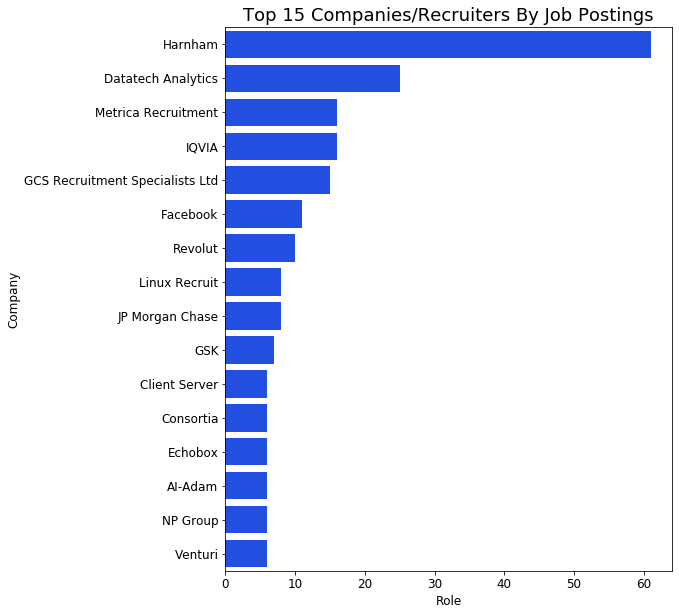

In [6]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 10))

#Dataset relating to recruiters
rec_df = df.groupby('Company').count().sort_values(by='Role', ascending=False).reset_index()[['Company', 'Role']].copy()

# Plot the total crashes
sns.set_color_codes("bright")
sns.barplot(x="Role", y="Company", data=rec_df.loc[0:15,:],
            label="Total", color="b")

plt.title('Top 15 Companies/Recruiters By Job Postings', fontsize=18);

Unsurprisingly most of the frequently positing companies are recruiters. Although in greater London it seems Harnham and Datatech Analytics have the largest number of roles. It may be worth speaking directly with these 2 to understand more about the roles they contain. Out of interest Harnham have managed to find a different title for every role they've posted. 42 of their 59 roles contain some form of 'Data Scientist' and to not use the same titles feeds nicely into the next section.

In [7]:
list(df[(df['Role'].str.contains('Data Sci'))  & (df['Company']=='Harnham')]['Role'].values)

['Head of Data Science',
 'Product Data Scientist',
 'Data Scientist',
 'Data Scientist - Machine Learning',
 'Lead Data Scientist',
 'Data Science Analyst',
 'Senior Fraud Data Scientist - Remote Working',
 'Product Data Analyst/ Data Scientist - Remote Working',
 'Senior Data Scientist',
 'Lead Data Scientist - Remote Working',
 'Senior Data Scientist - Home Working',
 'Product Data Scientist- Remote Working',
 'Fraud Data Scientist',
 'Computer Vision Data Scientist',
 'Lead Payments Fraud Data Scientist',
 'Data Scientist - Credit Decisioning',
 'Data Science and Data Engineering Director',
 'Junior Data Scientist',
 'Data Scientist - NLP',
 'Senior NLP Data Scientist',
 'Senior Data Scientist/ Natural Language Processing (NLP)',
 'Head of Data Science - Currently Remote Working',
 'Lead Data Scientist - Travel',
 'Head of Data Science and Machine Learning Engineering',
 'Data Science',
 'Data Scientist/ Senior Data Scientist',
 'Lead Fraud Data Scientist',
 'Director of Data Scien

### Job titles

The job title will be able to reveal information relating to the seniority of the job and filter out the roles irrelevant to apply to.

In [8]:
#Set to lower case so capitalised titles don't get counted separately
df['Role'] = df['Role'].apply(lambda x: x.lower())

#Group by Role to investigate different types
df_grp = df.groupby('Role').count().reset_index().sort_values(by='Company', ascending=False)[['Role', 'Company']]

print("Number of unique job roles:", df_grp.shape[0])

print("Number of titles used more than once:", df_grp[df_grp.Company > 1].shape[0])

df_grp[df_grp.Company > 2]

Number of unique job roles: 452
Number of titles used more than once: 33


,Role,Company
121,data scientist,76
374,senior data scientist,31
260,machine learning engineer,15
239,lead data scientist,12
217,head of data science,8
104,data science engineer,4
96,data science consultant,4
108,data science manager,4
26,analytics manager,4
231,junior data scientist,4


Data Scientist is or machine learning engineer are the highest returning results for job title (Phew!). However it seems there's a lot of variation in titles used and over 400 job titles only used once. <br/>

I also believe some of the results returned do not fit the role of a data scientist and one of these that caught my eye are roles containing 'manager'. I shall investigate these further. 

In [9]:
print("Number of roles containing 'Manager':",  df[df['Role'].str.contains("manager")].shape[0])
df[df['Role'].str.contains("manager")]

Number of roles containing 'Manager': 38


,Role,Company,Location,Contract,Salary,Job_description
1,data science manager,Isharat,London NW1,-,-,We are looking for a Data Science Manager who ...
2,fraud analytics manager,Harnham,London,Permanent,"£50,000 - £70,000 a year",FRAUD ANALYTICS MANAGERLONDON - CURRENTLY FLEX...
5,"commercial analytics manager, digital analytic...",Pandora,United Kingdom,-,-,"We are building a diverse team of thinkers, ma..."
38,data science manager,Sia Partners,London EC1A,-,-,Company Description Sia Partners is a speciali...
40,machine learning solutions architect/specialis...,AWS EMEA SARL (UK Branch),London,-,-,Must have 7-10 years of experience in senior t...
44,"manager, household finance and economic data s...",Financial Conduct Authority,London E20,-,"£70,000 - £95,000 a year","Location 12 Endeavour Square, London, E20 1JN ..."
61,digital platform product manager - applied ai/...,JP Morgan Chase,London E14,-,-,About J.P. Morgan Corporate & Investment Bank ...
115,"senior manager, supply chain data science eu",Amazon UK Services Ltd.,London,-,-,A Master Degree in a highly quantitative field...
140,"product manager, advanced analytics - real tim...",Visa,London,-,-,Company Description Fascinated by the future a...
165,"data science manager, ads infra",Facebook,London,-,-,We're looking for analytics leaders to work on...


36 of the jobs contain manager and most are for some form of data science manager or analytics manager. However a product manager role is not relevant to this data science search and shall be removed. 

In [10]:
df = df[~df['Role'].str.contains("product manager")]

I will class each job titles into the following categories:

- Lead: Any title containing lead, chief, head or manager
- Senior: Any title containing senior
- Graduate: Any title containing graduate
- Regular: Will class anything else as a regular role

I'm sure there will be some roles that end up getting classed as regular when in reality there are a more senior or more junior role. However, this seems currently to be a better way to narrow down jobs based on titles.

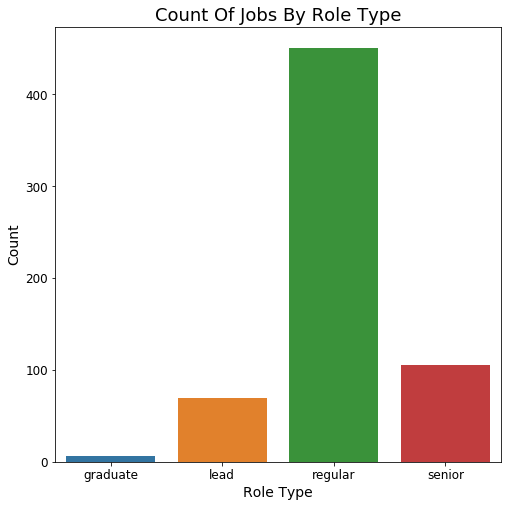

In [11]:
# Function to return the type of role based on keywords in the title.
def role_type(x):
    if 'lead' in x:
        return 'lead'
    elif 'head' in x:
        return 'lead'
    elif 'chief' in x:
        return 'lead'
    elif 'senior' in x:
        return 'senior'
    elif 'graduate' in x:
        return 'graduate'
    else:
        return 'regular'
    
df['Role_Type'] = df['Role'].apply(role_type)

job_df = df.groupby('Role_Type').count().reset_index()[['Role_Type', 'Role']]

f, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x='Role_Type', y='Role', data=job_df)

ax.set_title('Count Of Jobs By Role Type', fontsize=18)
ax.set_xlabel('Role Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14);

### Contract Type

Another important aspect to look into for a job search is whether the role is permanent or contract. Not all adverts on indeed specify this but will look into the split of permanent, contract, missing.

In [12]:
print('Roles with a contract type specified:', round(df[df['Contract']!='-'].groupby('Contract')['Role'].count().sum()/len(df),2)*100, '%')
df.groupby('Contract')['Role'].count().reset_index()

Roles with a contract type specified: 40.0 %


,Contract,Role
0,-,376
1,Apprenticeship,4
2,Contract,33
3,"Full-time, Contract",7
4,"Full-time, Contract, Permanent",1
5,"Full-time, Internship",1
6,"Full-time, Part-time",1
7,"Full-time, Part-time, Contract, Apprenticeship",2
8,"Full-time, Part-time, Contract, Permanent",1
9,"Full-time, Part-time, Internship",1


41% of roles have a type of contract associated with them. It may be possible to further investigate the ones without a contract type and find out from their description. For now an assumption shall be made that these are permanent. There are roles with only a count of 1 that contain a number of different contract types. I will class the contracts as the following:

- Contract: Anything that has 'contract' or 'temporary' associated with it
- Apprenticeship
- Internship
- Permanent: Any contract that is classed as 'Full-time' or 'Permanent'

In [13]:
#Function to return the contract type 
def contract_type(x):
    if re.search('Contract', x):
        return 'Contract'
    if re.search('Temporary', x):
        return 'Contract'
    if re.search('Full-time', x):
        return 'Permanent'
    if re.search('Permanent', x):
        return 'Permanent'
    if re.search('Internship', x):
        return 'Internship'
    else:
        return x
    
df['Contract_Type'] = df['Contract'].apply(contract_type)
df.groupby('Contract_Type')['Role'].count().reset_index()


,Contract_Type,Role
0,-,376
1,Apprenticeship,4
2,Contract,45
3,Internship,7
4,Part-time,6
5,Permanent,193


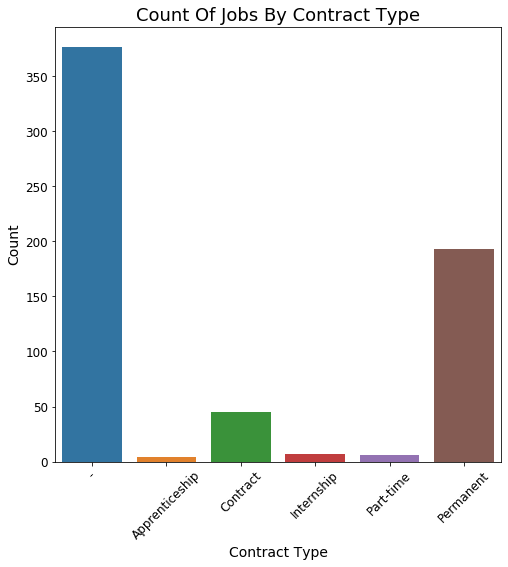

In [14]:
contract_df = df.groupby('Contract_Type').count().reset_index()[['Contract_Type', 'Role']]

f, ax = plt.subplots(figsize=(8,8))
plt.xticks(rotation=45)

sns.barplot(x='Contract_Type', y='Role', data=contract_df)

ax.set_title('Count Of Jobs By Contract Type', fontsize=18)
ax.set_xlabel('Contract Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14);

I shall remove Part-time and apprenticeship roles as these are not relevant to me and may just add noise to the data (in particular the apprenticeship job descriptions).

In [15]:
#Remove part time
df = df[(df['Contract_Type']!='Part-time') & (df['Contract_Type']!='Apprenticeship')]

### Program Type

Looking into whether Python or R is specified in the job description is not hugely important but more out of curiosity. 

There's a lot more to data science that just what programming language is used however it's useful to know the breakdown of jobs requiring Python or R in the current market

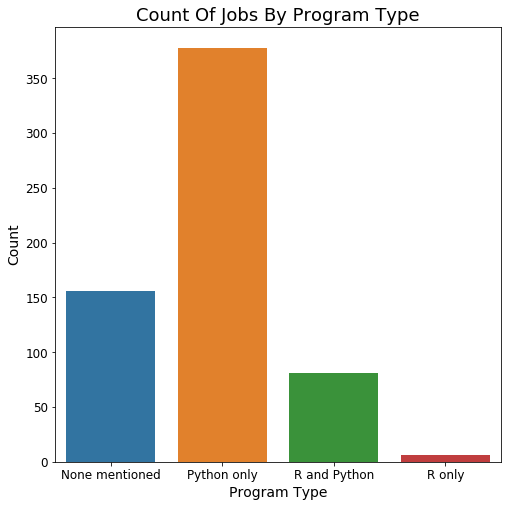

In [16]:
# Function to return the program 
def program_req(x):
    if re.search(' R ', x):
        if re.search('python', x.lower()):
            return 'R and Python'
        else:
            return 'R only'
    elif re.search('python', x.lower()):
            return 'Python only'
    else:
        return 'None mentioned'  
    
df['Program'] = df['Job_description'].apply(program_req)

prog_df = df.groupby('Program').count().reset_index()[['Program', 'Role']]

f, ax = plt.subplots(figsize=(8,8))

sns.barplot(x='Program', y='Role', data=prog_df)

ax.set_title('Count Of Jobs By Program Type', fontsize=18)
ax.set_xlabel('Program Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14);

Python is overwhelmingly the program of choice in the job descriptions. This is higher than I thought it would be and makes the case for using Python over R for producing data science related analysis / models.

### Salary

Like the contract type, salary is not always contained on indeed but when it is a temporary role is usually specified in the rate per hour, day, etc. and a permanent position in the salary per year. 

In [17]:
df.groupby(['Contract_Type', 'Salary']).count().reset_index()

,Contract_Type,Salary,Role,Company,Location,Contract,Job_description,Role_Type,Program
0,-,-,308,308,308,308,308,308,308
1,-,£10.43 an hour,1,1,1,1,1,1,1
2,-,"£100,000 a year",2,2,2,2,2,2,2
3,-,"£120,000 - £130,000 a year",1,1,1,1,1,1,1
4,-,"£120,000 - £140,000 a year",1,1,1,1,1,1,1
5,-,"£28,000 - £35,000 a year",1,1,1,1,1,1,1
6,-,"£30,000 - £40,000 a year",1,1,1,1,1,1,1
7,-,"£30,000 a year",2,2,2,2,2,2,2
8,-,"£35,000 - £40,000 a year",1,1,1,1,1,1,1
9,-,"£35,000 - £45,000 a year",1,1,1,1,1,1,1


From the grouped Contract type and salary it can be seen that the contract roles have a rate per hour, day, week or month whereas the permanent positions are all per year. There is 1 role that has no contract specified but has a salary of £10.43 per hour so I will change the contract type to 'Contract'. Roles that have no contract type specified but annual salaries will be changed to 'Permanent' contract types.

In [18]:
#Fix the contract type based on salary information

df.loc[df['Salary'].str.contains('an hour'), 'Contract_Type'] = 'Contract'
df.loc[(df['Salary'].str.contains('a year')) & (df['Contract_Type'] == '-'), 'Contract_Type'] = 'Permanent'
df.loc[(df['Salary'].str.contains('a year')) & (df['Contract_Type'] == 'Contract'), 'Contract_Type'] = 'Permanent'

In [19]:
df.groupby(['Contract_Type', 'Salary']).count().reset_index()

,Contract_Type,Salary,Role,Company,Location,Contract,Job_description,Role_Type,Program
0,-,-,308,308,308,308,308,308,308
1,-,£40 a day,1,1,1,1,1,1,1
2,Contract,-,17,17,17,17,17,17,17
3,Contract,£10.43 an hour,1,1,1,1,1,1,1
4,Contract,£200 - £700 a day,1,1,1,1,1,1,1
5,Contract,£350 - £450 a day,2,2,2,2,2,2,2
6,Contract,£40 - £45 an hour,1,1,1,1,1,1,1
7,Contract,£400 - £450 a day,1,1,1,1,1,1,1
8,Contract,£400 - £475 a day,1,1,1,1,1,1,1
9,Contract,£450 - £520 a day,1,1,1,1,1,1,1


### Extract salary

Some jobs have a range for their salary. In these cases I will take the median value for their salary.

In [20]:
def min_salary(x):
    if (re.search('- £', x)):
        return re.search('£(.*?) -', x).group(1)
    else:
        ""

def max_salary(x):
    if (re.search('- £', x)):
        return re.search('- £(.*?) a', x).group(1)
    elif (re.search('£', x)):
        return re.search('£(.*?) a', x).group(1)
    else:
        ""
        
def salary(x):
    if (x['Min_Salary']==0):
        return x['Max_Salary']
    else:
        return x['Median_Salary']

In [21]:
#return min and max salaries when there is a range
df['Min_Salary'] = df['Salary'].apply(min_salary)
df['Max_Salary'] = df['Salary'].apply(max_salary)
df = df.fillna(0)

#Convert to string to remove commas
df['Max_Salary'] = df['Max_Salary'].astype(str)
df['Min_Salary'] = df['Min_Salary'].astype(str)

#remove commas from the salary amount
df['Max_Salary'] = df['Max_Salary'].str.replace(',', '', regex=True).astype(float)
df['Min_Salary'] = df['Min_Salary'].str.replace(',', '', regex=True).astype(float)

#Calculate median salary
df['Median_Salary'] = (df['Min_Salary'] + ((df['Max_Salary'] - df['Min_Salary'])/2))

#Set median_new salary as the salary value for when there isn't a salary range and the median when there is a range
df['Median_New'] =  df.apply(salary, axis=1)

#Drop created salaries no longer needed and rename median_new
df.drop(columns={'Min_Salary', 'Max_Salary', 'Median_Salary'}, inplace=True)
df.rename(columns={'Median_New':'Median_Salary'}, inplace=True)

#### Converting contract rates to same base

As the contract rates vary between per hour/ per week etc. they need to be converted into the same rate. I've chosen on a daily rate.

In [22]:
df['Contract_Rate'] = 0

#Convert the contract rate to daily
df.loc[(df['Salary'].str.contains('an hour')), 'Contract_Rate'] = df.loc[(df['Salary'].str.contains('an hour')), 'Median_Salary'] * 8
df.loc[(df['Salary'].str.contains('a day')), 'Contract_Rate'] = df.loc[(df['Salary'].str.contains('a day')), 'Median_Salary']
df.loc[(df['Salary'].str.contains('a week')), 'Contract_Rate'] = df.loc[(df['Salary'].str.contains('a week')), 'Median_Salary'] / 5
df.loc[(df['Salary'].str.contains('a month')), 'Contract_Rate'] = df.loc[(df['Salary'].str.contains('a month')), 'Median_Salary'] / 21

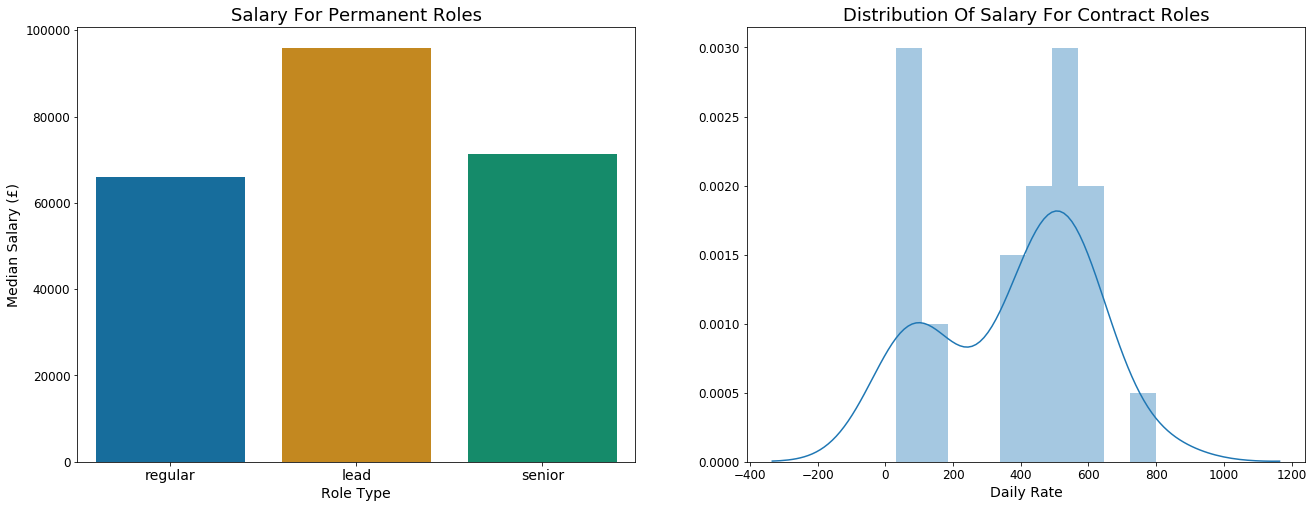

In [23]:
#Title vs Salary
f, axes = plt.subplots(1, 2, figsize=(22, 8))

sns.barplot(x="Role_Type", y="Median_Salary",
            data=df[(df['Contract_Type']=='Permanent') & (df['Median_Salary']>0)], palette="colorblind", ax=axes[0],
            ci=None)


sns.distplot(df[df['Contract_Rate']>0]['Contract_Rate'], bins=10, ax=axes[1])

axes[0].set_title('Salary For Permanent Roles', fontsize=18)
axes[0].set_xlabel('Role Type', fontsize=14)
axes[0].set_xticklabels(['regular', 'lead', 'senior'], fontsize=14)
axes[0].set_ylabel('Median Salary (£)', fontsize=14)

axes[1].set_title('Distribution Of Salary For Contract Roles', fontsize=18)
axes[1].set_xlabel('Daily Rate', fontsize=14);

Some of the contract rates seem low from the plot. As can be noted from the table below I believe whoever has put the advert up has made a mistake. Most of the £400-500 a week rates are most likely £400-500 a day and would match up with the other contracting roles.

In [24]:
df[(df['Contract_Rate'] > 0) & (df['Contract_Rate'] < 300)][['Role', 'Salary']]

,Role,Salary
6,data scientist,£40 a day
72,data scientist,£465 a week
76,intern in mobile diagnostics and machine learning,£10.43 an hour
152,risk data scientist - r programming,£500 a week
401,data scientist,£500 - £600 a week
514,data scientist sc cleared,£640 a month
532,senior project manager - bi & advanced analytics,£500 a week
615,big data devops engineer,£600 - £650 a week


##  3. Topic modelling

### Removing closely worded job descriptions

Before apply topic modelling to the job descriptions in the data set, job adverts that are very similar but not identical need to be removed. I've decided the best way to remove these adverts is to transform to a vector based on their word counts and calculate their cosine similarity scores. Anything that is close to 1 without equalling 1 is very likely to be a repetition of an advert which contains a small difference.

In [25]:
corpus = df['Job_description']

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

corpus = df['Job_description']
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(corpus)

#Dataframe with cosine similarties
cos_df = pd.DataFrame(cosine_similarity(X_train_counts))

#Dataframe for job advert and similarity with every other advert
i, j = np.indices(cos_df.shape).reshape(2, -1)
cos_values = cos_df.values.reshape(-1)
cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'sim':cos_values})

#Any advert that has a cosine similarity above 0.98 and doesn't equal itself
cos_rem = cos_sim_df[(cos_sim_df['sim']>0.98)&(i!=j)]

#Method to remove duplicates but keep first instance. Trying to drop duplicates on i and j column wouldn't work as the numbers don't duplicate in those
#columns. Setting another column that combines their values ensure that duplicates can be dropped.

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

#Drop from original dataframe
df = df[~df.index.isin(drop_rows)]
df = df.reset_index()
df.drop(columns={'index'}, inplace=True)

Using this method has removed 32 rows that were not identical but had cosine similarity scores of over 0.98.

In [27]:
corpus = df['Job_description']

In [28]:
import nltk 

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

#Function to pre-process the text information

def normalize_document(doc):
    
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I (ignore case), re.A (ASCII-only matching)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in filtered_tokens]
    
    # Remove words that are only one character.
    lem_text = [token for token in lem_text if len(token) > 1]
    
    # Remove numbers, but not words that contain numbers.
    lem_text = [token for token in lem_text if not token.isnumeric()]
    
    doc = ' '.join(lem_text)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)

Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora

Gensim requires the words (tokens) to be converted to unique ids, which can be done by creating a dictionary that maps the words to ids.
Once the dictionary has been created a bag of words corpus can be created that contains the word id and the its frequency in each document. It is effectively an equivalent of a Document-Term matrix.

In [29]:
from nltk.tokenize import word_tokenize
import gensim.corpora as corpora

#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in norm_corpus]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=20, no_above=0.5)

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

To find the optimum number of topics, models will be built for a range of topic sizes and the one with the highest coherence score will be chosen. A previous search into optimum numbers has narrowed down the search to  be between 8 and 15.

In [30]:
def compute_coherence_values(corpus, dictionary, texts, end, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end, step):
    
        # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               random_state=123,
                                               chunksize=100,
                                               passes=500, #number of passes was investigated. At 500 the coherence score will remain relatively similar
                                               #with any further increase. As the document is quite small this number of passes makes sense.
                                               per_word_topics=True)
        model_list.append(lda_model)
        
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

In [31]:
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary = id2word, texts=texts, start=8, end=16, step=1)

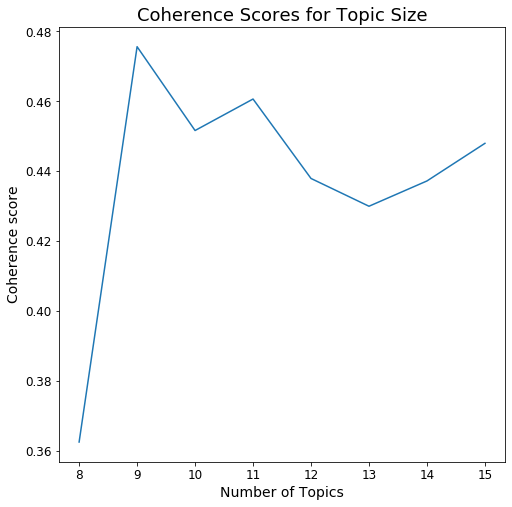

In [32]:
# Show graph
end=16; start=8; step=1;
x = range(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
plt.title('Coherence Scores for Topic Size', fontsize=18)
plt.show();

9 topics has the highest coherence score and will be chosen to build the final model

In [33]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9, 
                                       random_state=123,
                                       chunksize=100,
                                       passes=500,
                                       per_word_topics=True)

In [34]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4756081123111222


The top 10 keywords for each topic are as follows. 

In [35]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"client" + 0.014*"solution" + 0.012*"analytics" + 0.011*"management" '
  '+ 0.011*"project" + 0.011*"service" + 0.009*"across" + 0.008*"people" + '
  '0.008*"support" + 0.008*"develop"'),
 (1,
  '0.030*"healthcare" + 0.015*"health" + 0.015*"patient" + 0.014*"client" + '
  '0.013*"solution" + 0.012*"clinical" + 0.012*"statistical" + 0.011*"project" '
  '+ 0.010*"ability" + 0.010*"programming"'),
 (2,
  '0.033*"research" + 0.016*"language" + 0.015*"computer" + 0.013*"deep" + '
  '0.013*"nlp" + 0.010*"technique" + 0.009*"processing" + 0.009*"problem" + '
  '0.009*"phd" + 0.009*"algorithm"'),
 (3,
  '0.022*"product" + 0.016*"people" + 0.013*"youll" + 0.010*"help" + '
  '0.010*"day" + 0.010*"build" + 0.010*"customer" + 0.009*"building" + '
  '0.008*"way" + 0.007*"year"'),
 (4,
  '0.015*"status" + 0.014*"information" + 0.014*"gender" + 0.013*"employment" '
  '+ 0.012*"equal" + 0.012*"disability" + 0.011*"employer" + 0.009*"sexual" + '
  '0.009*"orientation" + 0.008*"age"'),
 (5

There needs to be some human input in terms of naming the topics. For these 9 that is quite straightforward as it's evident in the majority of the topics that the keywords are connected by 1 or 2 terms. Obviously, the topics related to equal opportunities and referral scheme aren't particularly helpful, but this information is included in most adverts. A possible improvement would include words associated with these topics in the stop words.

In [36]:
lda_dict = {0:'Project management & Supporting clients', 
            1:'Healthcare', 
            2:'Deep Learning, NLP & Computer Vision', 
            3:'Building Products',
            4:'Equal Opportunities',
            5:'Analytics & Statistical Modelling',
            6:'Senior Projects',
            7:'ML, Big Data & Cloud Computing',
            8:'Referral Scheme', 
           '-':'-'}

### Top 3 topics for each document

In LDA models, each document is composed of multiple topics, although 1 or 2 will be dominant. For this work, the top 3 topics in each document will be highlighted.

In [37]:
topics_df1 = pd.DataFrame()
topics_df2 = pd.DataFrame()
topics_df3 = pd.DataFrame()
 
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if len(row) >= 3:        
            if j ==0:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            elif j ==1:
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            elif j ==2:
                topics_df3 = topics_df3.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            else:
                break
        elif len(row) == 2:
            if j ==0:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            elif j ==1:
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
                topics_df3 = topics_df3.append(pd.Series(['-', '-']), ignore_index=True)
        elif len(row) == 1:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
                topics_df2 = topics_df2.append(pd.Series(['-', '-']), ignore_index=True)  
                topics_df3 = topics_df3.append(pd.Series(['-', '-']), ignore_index=True)        
                
            
topics_df1.rename(columns={0:'1st Topic', 1:'1st Topic Contribution'}, inplace=True)
topics_df2.rename(columns={0:'2nd Topic', 1:'2nd Topic Contribution'}, inplace=True)
topics_df3.rename(columns={0:'3rd Topic', 1:'3rd Topic Contribution'}, inplace=True)

topics_comb = pd.concat([topics_df1, topics_df2, topics_df3],  axis=1, sort=False)

#Join topics dataframe to original data
df = pd.concat([df, topics_comb], axis=1, sort=False)

#Combine the top 3 into one column so it's easier to analyse
df['Top 3 Topics'] = df['1st Topic'].apply(lambda x: lda_dict[x].join(" ,") + " ").astype(str) + df['2nd Topic'].apply(lambda x: lda_dict[x].join(" ,") + " ").astype(str) + \
df['3rd Topic'].apply(lambda x: lda_dict[x]).astype(str)

pyLDAVis is the most commonly used and best way to visualise the information contained in a topic model.

In [38]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=                       x                  y  topics  cluster  \
topic                                                          
0     -0.092536287939199  0.013986620606966       1        1   
5     -0.042905028783059 -0.119338826098754       2        1   
3     -0.042917038537938 -0.043104898947259       3        1   
2      0.082897174412961 -0.040595863593312       4        1   
6      0.075455266468517 -0.061417975255701       5        1   
4     -0.074275920642062  0.241786167855302       6        1   
7      0.264519949258649  0.050961712407745       7        1   
8     -0.004449452863473 -0.001282047351433       8        1   
1     -0.165788661374396 -0.040994889623554       9        1   

                     Freq  
topic                      
0      18.167362213134766  
5      18.035430908203125  
3      17.879997253417969  
2      11.386377334594727  
6       8.779766082763672  
4       7.534379005432129  
7       6.859143257141113  
8       6.533695220947266  
1       4.823848247528076  , topic_info=           Term                 Freq                Total Category  \
276    research  450.000000000000000  450.000000000000000  Default   
13       client  716.000000000000000  716.000000000000000  Default   
576    engineer  423.000000000000000  423.000000000000000  Default   
167          ai  413.000000000000000  413.000000000000000  Default   
879  healthcare  181.000000000000000  181.000000000000000  Default   
..          ...                  ...                  ...      ...   
44      improve   29.345235824584961  220.462127685546875   Topic9   
168    analysis   33.112743377685547  507.240295410156250   Topic9   
306       world   29.866638183593750  401.690704345703125   Topic9   
322      better   26.017175674438477  147.559799194335938   Topic9   
117   including   25.950435638427734  415.887908935546875   Topic9   

                logprob             loglift  
276  30.000000000000000  30.000000000000000  
13   29.000000000000000  29.000000000000000  
576  28.000000000000000  28.000000000000000  
167  27.000000000000000  27.000000000000000  
879  26.000000000000000  26.000000000000000  
..                  ...                 ...  
44   -5.113299846649170   1.014999985694885  
168  -4.992499828338623   0.302500009536743  
306  -5.095699787139893   0.432700008153915  
322  -5.233600139617920   1.296100020408630  
117  -5.236199855804443   0.257400006055832  

[540 rows x 6 columns], token_table=      Topic               Freq     Term
term                                   
160       1  0.052315324544907  ability
160       2  0.368387073278427  ability
160       3  0.172204613685608  ability
160       4  0.058854740113020  ability
160       5  0.010899025946856  ability
...     ...                ...      ...
980       2  0.045476138591766    youre
980       3  0.352440088987350    youre
980       4  0.045476138591766    youre
980       5  0.034107103943825    youre
980       7  0.477499455213547    youre

[1829 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 4, 3, 7, 5, 8, 9, 2])

Before outputting I can remove the job adverts not relevant for my search

In [39]:
data_out = df[(df['Role_Type']=='regular') & (df['Contract_Type']!='Internship') & (df['Contract_Type']!='Apprenticeship') & 
   (df['Contract_Type']!='Part-Time')]

data_out.to_csv('Filtered_Job_Search.csv')